In [1573]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")


# 1. Data Load

In [1574]:
train=pd.read_csv(r"C:\Users\USER\Desktop\Kaggle_Titanic\Titanic_data\train.csv")
test=pd.read_csv(r"C:\Users\USER\Desktop\Kaggle_Titanic\Titanic_data\test.csv")

# 2. 결측치 처리 

In [1575]:
# 결측치 처리를 위한 데이터 병합
data=pd.concat([train, test], sort=False)

In [1576]:
# 결측값 확인
data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

pandas_profiling을 이용하여 결측값을 어떻게 채울지 파악

In [1577]:
# import pandas_profiling
# data[['Age', 'Cabin','Fare','Embarked']].profile_report()

- 최빈값

In [1578]:
data['Embarked'].fillna('S', inplace=True)  # 결손값을 'S'로 채움

- 평균값

In [1579]:
data['Fare'].fillna(np.mean(data['Fare']), inplace=True)

- 평균, 표준편차를 기반으로 랜덤 값 대체 (정규분포)

In [1580]:
age_avg=data['Age'].mean()
age_std=data['Age'].std()
data['Age'].fillna(np.random.randint(age_avg-age_std, age_avg+age_avg), inplace=True)

# 3. 파생변수

<AxesSubplot:xlabel='FamilySize', ylabel='count'>

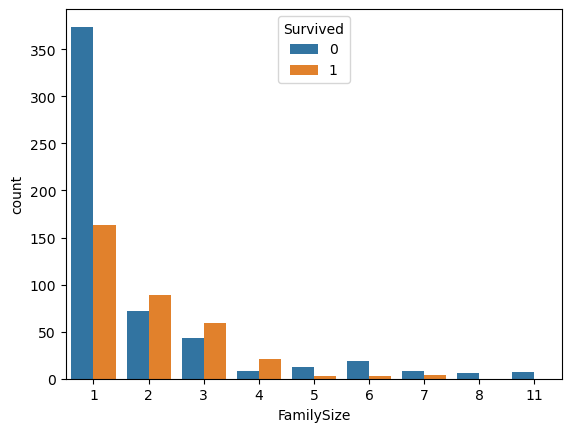

In [1581]:
import seaborn as sns
%matplotlib inline 
data['FamilySize']=data['Parch']+ data['SibSp'] + 1 # 가족 구성원 + 본인(+1)
train['FamilySize']=data['FamilySize'][:len(train)]
test['FamilySize']=data['FamilySize'][len(train):]
sns.countplot(x='FamilySize', hue='Survived',data=train)

=> 5명이상인 경우 생존률이 급격히 하락함, 1명일 경우 매우 높음

-> IsAlone이라는 "한명이다 vs 아니다"를 의미하는 column 생성

In [1582]:
data['IsAlone']=0
data.loc[data['FamilySize']==1, 'IsAlone']=1

train['IsAlone']=data['IsAlone'][:len(train)]
test['IsAlone']=data['IsAlone'][len(train):]

<AxesSubplot:xlabel='IsAlone', ylabel='count'>

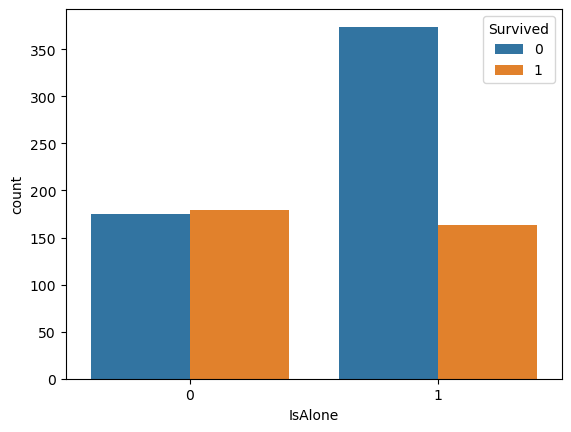

In [1583]:
sns.countplot(x='IsAlone', hue='Survived',data=train)

# 4. 사용하지 않을 특성 제거

In [1584]:
delete_col = ['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin']
data.drop(delete_col, axis=1, inplace=True)
#axis=1 -> 열 제거
#axis=0 -> 행 제거

In [1585]:
# 카테고리변수 값 매핑
data['Sex'].replace(['male','female'], [0,1], inplace=True)

data['Embarked']=\
    data['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype(int)

# 5. 모델링

In [1586]:
# 캐글에서 지정한 Test Set 따로 저장
train=data[:len(train)]
test=data[len(train):]

In [1587]:
base_X_train=train.drop('Survived', axis=1)
base_y_train=train['Survived']

base_X_test=test.drop('Survived',axis=1)
# y_test 캐글만 알고 있고, 우리가 예측한 y_pred를 캐글에 submit해서 성능을 확인해야함!

------

6. 여러 모델 사용 (로지스틱 회귀, 랜덤 포레스트, LightGBM)

<로지스틱 회귀 모델>

In [1588]:
from sklearn.linear_model import LogisticRegression

clf=LogisticRegression(penalty='l2', solver='sag', random_state=0)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

#LogisticRegeression의 파라미터
#penalty(손실): 정규화 방법(L1)
#solver(답 찾는 방법): sag (stochastic Average Gradient) "확률적 경사 하강법"
# 랜덤시드 고정

<랜덤 포레스트>

In [1589]:
from sklearn.ensemble import RandomForestClassifier

clf= RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

# 랜덤 포레스트의 파라미터
# n_estimators : 트리 개수
# max_depth : 트리의 깊이
# 랜덤 시드 고정

<LightGBM>

<Light GBM>

주의할 점!

1. 카테고리변수를 리스트형식으로 선언해줘야함!
2. Light GBM 타입으로 데이터셋을 변환해야함!

In [1590]:
# 성능 평가를 위해 데이터셋 분할 (CV안함)
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid= \
    train_test_split(base_X_train, base_y_train, test_size=0.3, random_state=0, stratify=base_y_train)
    
# stratify에 y_train -> 테스트셋과 트레이닝 셋의  목적 변수 class 비율 같아짐
# survived값까지 모두 알고 있는 train.csv에서만 데이터셋 분할 (test는 사용하지 않음) *보편적인 분할

In [1591]:
# 카테고리변수 선언
categorical_features=['Embarked', 'Pclass', 'Sex']

In [1592]:
import lightgbm as lgb

#LGB 데이터셋으로 변환
lgb_train=lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
lgb_eval=lgb.Dataset(X_valid, y_valid, reference=lgb_train,
                     categorical_feature=categorical_features)

In [1593]:
params={
    'objective':'binary',    # 모델이 최적화하려는 손실함수 결정 
                            #-> binary -> 이진 분류 문제에 대한 로지스틱 손실 함수 사용
}

In [1594]:
lgb_model = lgb.train(params, 
                  lgb_train,
                  valid_sets=[lgb_train, lgb_eval], # train, eval 셋을 모두 사용하여 성능 평가
                  verbose_eval=10,      # 학습 과정에서 로그를 얼마나 자세히 출력할지 (10 : 10개의 학습 단계마다 로그 출력)
                  num_boost_round=1000,   # 부스팅 라운드 설정 :1000개의 트리를 만들어봄 (비교적 많은 편)
                  early_stopping_rounds=10)  # 조기 종료를 위한 라운드 수 : 10 (성능향상이 없는 경우 10번의 추가 라운드 진행 후 학습 종료)

[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [1595]:
# fit 된 모델로 예측값 생성
y_pred=lgb_model.predict(X_valid, num_iteration=lgb_model.best_iteration)
#교재에 잘못 나와있음 (X_test가 아닌 X_valid로 예측해야함)

In [1596]:
# 선형 예측값을 이진 값으로 변경
y_pred=(y_pred>0.5).astype(int)

In [1597]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8171641791044776


# 7. 하이퍼 파라미터 튜닝

- Grid Search
- Bayesian Optimization
- Hyperopt
- Optuna

<optuna 사용>

In [1598]:
import optuna #pip install optuna4
from sklearn.metrics import log_loss

def objective(trial):
    params={
        'objective':'binary',
        'max_bin':trial.suggest_int('max_bin', 255,500),    # trial.suggest_int()로 탐색 범위 지정(255~500)
        'learning_rate':0.05,   #따로 조정 x
        'num_leaves':trial.suggest_int('num_leaves', 32, 128) # trial.suggest_int()로 탐색 범위 지정(32~128)
    }
    
    # 매번 data set 선언을 함수안에서 해줘야함 (optuna에서 반복적으로 실행하기 때문에 함수안에서 data set선언 해야함)
    lgb_train=lgb.Dataset(X_train, y_train,
                    categorical_feature=categorical_features)
    lgb_eval=lgb.Dataset(X_valid, y_valid,
                     categorical_feature=categorical_features)

    model = lgb.train(params,
                  lgb_train,
                  valid_sets=[lgb_train, lgb_eval],
                  verbose_eval=0,
                  num_boost_round=1000,
                  early_stopping_rounds=10)
    y_pred_valid=model.predict(X_valid, num_iteration=model.best_iteration)

    score=log_loss(y_valid, y_pred_valid)

    return score

In [1599]:
#optuna Study객체 생성
study=optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
#sampler : 샘플링 전략 (랜덤샘플링)

#optimaize() -> 목적함수인 objective (위에서 만든 함수)를 최적화 (최대 40번)
study.optimize(objective, n_trials=40)
study.best_params # study객체의 best_params 속성 -> 파라미터 튜닝 -> 파라미터 조합 제공)


[I 2023-08-22 21:09:22,328] A new study created in memory with name: no-name-a4673cea-60f9-4084-9aa7-a7a4871a24de
[I 2023-08-22 21:09:22,395] Trial 0 finished with value: 0.43178651912618143 and parameters: {'max_bin': 390, 'num_leaves': 101}. Best is trial 0 with value: 0.43178651912618143.
[I 2023-08-22 21:09:22,464] Trial 1 finished with value: 0.43178651912618143 and parameters: {'max_bin': 403, 'num_leaves': 84}. Best is trial 0 with value: 0.43178651912618143.


[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 193
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2023-08-22 21:09:22,531] Trial 2 finished with value: 0.43178651912618143 and parameters: {'max_bin': 359, 'num_leaves': 94}. Best is trial 0 with value: 0.43178651912618143.
[I 2023-08-22 21:09:22,593] Trial 3 finished with value: 0.43178651912618143 and parameters: {'max_bin': 362, 'num_leaves': 118}. Best is trial 0 with value: 0.43178651912618143.
[I 2023-08-22 21:09:22,654] Trial 4 finished with value: 0.43178651912618143 and parameters: {'max_bin': 492, 'num_leaves': 69}. Best is trial 0 with value: 0.43178651912618143.


[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 193
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2023-08-22 21:09:22,720] Trial 5 finished with value: 0.43178651912618143 and parameters: {'max_bin': 449, 'num_leaves': 83}. Best is trial 0 with value: 0.43178651912618143.
[I 2023-08-22 21:09:22,788] Trial 6 finished with value: 0.43178651912618143 and parameters: {'max_bin': 394, 'num_leaves': 121}. Best is trial 0 with value: 0.43178651912618143.
[I 2023-08-22 21:09:22,849] Trial 7 finished with value: 0.43178651912618143 and parameters: {'max_bin': 272, 'num_leaves': 40}. Best is trial 0 with value: 0.43178651912618143.
[I 2023-08-22 21:09:22,911] Trial 8 finished with value: 0.43178651912618143 and parameters: {'max_bin': 259, 'num_leaves': 112}. Best is trial 0 with value: 0.43178651912618143.


[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 193
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2023-08-22 21:09:22,980] Trial 9 finished with value: 0.43178651912618143 and parameters: {'max_bin': 446, 'num_leaves': 116}. Best is trial 0 with value: 0.43178651912618143.
[I 2023-08-22 21:09:23,064] Trial 10 finished with value: 0.43178651912618143 and parameters: {'max_bin': 495, 'num_leaves': 109}. Best is trial 0 with value: 0.43178651912618143.


[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 193
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2023-08-22 21:09:23,229] Trial 11 finished with value: 0.43178651912618143 and parameters: {'max_bin': 368, 'num_leaves': 107}. Best is trial 0 with value: 0.43178651912618143.
[I 2023-08-22 21:09:23,268] Trial 12 finished with value: 0.43178651912618143 and parameters: {'max_bin': 284, 'num_leaves': 94}. Best is trial 0 with value: 0.43178651912618143.
[I 2023-08-22 21:09:23,303] Trial 13 finished with value: 0.43178651912618143 and parameters: {'max_bin': 290, 'num_leaves': 123}. Best is trial 0 with value: 0.43178651912618143.
[I 2023-08-22 21:09:23,348] Trial 14 finished with value: 0.43178651912618143 and parameters: {'max_bin': 383, 'num_leaves': 72}. Best is trial 0 with value: 0.43178651912618143.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-08-22 21:09:23,384] Trial 15 finished with value: 0.43178651912618143 and parameters: {'max_bin': 320, 'num_leaves': 107}. Best is trial 0 with value: 0.43178651912618143.
[I 2023-08-22 21:09:23,419] Trial 16 finished with value: 0.43178651912618143 and parameters: {'max_bin': 367, 'num_leaves': 87}. Best is trial 0 with value: 0.43178651912618143.
[I 2023-08-22 21:09:23,459] Trial 17 finished with value: 0.43178651912618143 and parameters: {'max_bin': 259, 'num_leaves': 91}. Best is trial 0 with value: 0.43178651912618143.
[I 2023-08-22 21:09:23,499] Trial 18 finished with value: 0.43178651912618143 and parameters: {'max_bin': 405, 'num_leaves': 91}. Best is trial 0 with value: 0.43178651912618143.
[I 2023-08-22 21:09:23,535] Trial 19 finished with value: 0.43178651912618143 and parameters: {'max_bin': 487, 'num_leaves': 98}. Best is trial 0 with value: 0.43178651912618143.


[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 193
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2023-08-22 21:09:23,571] Trial 20 finished with value: 0.43178651912618143 and parameters: {'max_bin': 343, 'num_leaves': 74}. Best is trial 0 with value: 0.43178651912618143.
[I 2023-08-22 21:09:23,606] Trial 21 finished with value: 0.43178651912618143 and parameters: {'max_bin': 426, 'num_leaves': 37}. Best is trial 0 with value: 0.43178651912618143.
[I 2023-08-22 21:09:23,639] Trial 22 finished with value: 0.43178651912618143 and parameters: {'max_bin': 419, 'num_leaves': 97}. Best is trial 0 with value: 0.43178651912618143.
[I 2023-08-22 21:09:23,673] Trial 23 finished with value: 0.43178651912618143 and parameters: {'max_bin': 306, 'num_leaves': 44}. Best is trial 0 with value: 0.43178651912618143.
[I 2023-08-22 21:09:23,706] Trial 24 finished with value: 0.43178651912618143 and parameters: {'max_bin': 332, 'num_leaves': 67}. Best is trial 0 with value: 0.43178651912618143.
[I 2023-08-22 21:09:23,740] Trial 25 finished with value: 0.43178651912618143 and parameters: {'max_bin':

[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 193
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2023-08-22 21:09:23,780] Trial 26 finished with value: 0.43178651912618143 and parameters: {'max_bin': 498, 'num_leaves': 41}. Best is trial 0 with value: 0.43178651912618143.
[I 2023-08-22 21:09:23,831] Trial 27 finished with value: 0.43178651912618143 and parameters: {'max_bin': 306, 'num_leaves': 47}. Best is trial 0 with value: 0.43178651912618143.
[I 2023-08-22 21:09:23,871] Trial 28 finished with value: 0.43178651912618143 and parameters: {'max_bin': 415, 'num_leaves': 56}. Best is trial 0 with value: 0.43178651912618143.
[I 2023-08-22 21:09:23,905] Trial 29 finished with value: 0.43178651912618143 and parameters: {'max_bin': 369, 'num_leaves': 55}. Best is trial 0 with value: 0.43178651912618143.
[I 2023-08-22 21:09:23,945] Trial 30 finished with value: 0.43178651912618143 and parameters: {'max_bin': 294, 'num_leaves': 42}. Best is trial 0 with value: 0.43178651912618143.


[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 193
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2023-08-22 21:09:23,985] Trial 31 finished with value: 0.43178651912618143 and parameters: {'max_bin': 416, 'num_leaves': 45}. Best is trial 0 with value: 0.43178651912618143.
[I 2023-08-22 21:09:24,024] Trial 32 finished with value: 0.43178651912618143 and parameters: {'max_bin': 303, 'num_leaves': 67}. Best is trial 0 with value: 0.43178651912618143.
[I 2023-08-22 21:09:24,061] Trial 33 finished with value: 0.43178651912618143 and parameters: {'max_bin': 456, 'num_leaves': 41}. Best is trial 0 with value: 0.43178651912618143.
[I 2023-08-22 21:09:24,098] Trial 34 finished with value: 0.43178651912618143 and parameters: {'max_bin': 461, 'num_leaves': 41}. Best is trial 0 with value: 0.43178651912618143.
[I 2023-08-22 21:09:24,139] Trial 35 finished with value: 0.43178651912618143 and parameters: {'max_bin': 495, 'num_leaves': 77}. Best is trial 0 with value: 0.43178651912618143.


[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 193
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2023-08-22 21:09:24,203] Trial 36 finished with value: 0.43178651912618143 and parameters: {'max_bin': 495, 'num_leaves': 90}. Best is trial 0 with value: 0.43178651912618143.
[I 2023-08-22 21:09:24,237] Trial 37 finished with value: 0.43178651912618143 and parameters: {'max_bin': 436, 'num_leaves': 35}. Best is trial 0 with value: 0.43178651912618143.
[I 2023-08-22 21:09:24,272] Trial 38 finished with value: 0.43178651912618143 and parameters: {'max_bin': 324, 'num_leaves': 43}. Best is trial 0 with value: 0.43178651912618143.
[I 2023-08-22 21:09:24,307] Trial 39 finished with value: 0.43178651912618143 and parameters: {'max_bin': 327, 'num_leaves': 43}. Best is trial 0 with value: 0.43178651912618143.


[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 193
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

{'max_bin': 390, 'num_leaves': 101}

In [1600]:
import lightgbm as lgb
from sklearn.metrics import log_loss

# 데이터셋 생성
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features, free_raw_data=False)
lgb_eval = lgb.Dataset(X_valid, y_valid, categorical_feature=categorical_features, free_raw_data=False)

# 모델 훈련
best_model = lgb.train(best_params,
                       lgb_train,
                       valid_sets=[lgb_train, lgb_eval],
                       verbose_eval=0,
                       num_boost_round=1000,
                       early_stopping_rounds=10)

# 검증 데이터에 대한 예측
y_pred_best = best_model.predict(X_valid, num_iteration=best_model.best_iteration)

# 예측 결과 평가
best_score = log_loss(y_valid, y_pred_best)
print(f"Best Log Loss: {best_score}")


[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 193
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

---

# 9. 교차검증

In [1601]:
y_train=train['Survived']
X_train=train.drop('Survived', axis=1)
X_test=test.drop('Survived',axis=1)

In [1602]:
import lightgbm as lgb
from sklearn.model_selection import KFold

y_preds=[]      # cv마다 만들어질 예측값리스트들을 저장하기 위한 리스트
models=[]       # cv마다 만들어질 model들을 저장하기 위한 리스트
oof_train=np.zeros((len(X_train))) # 전체 데이터 셋의 크기만큼의 배열 -> 각 fold의 데이터에 대한 예측 결과 (모든 예측 결과)

cv=KFold(n_splits=5, shuffle=True, random_state=0) #KFOLD객체 (5등분) 생성

categorical_features=['Embarked', 'Pclass', 'Sex'] # lgb 모델에 넘겨줄 카테고리형 특성들

params={
    'objective':'binary',
    'max_bin':300,
    'learning_rate':0.05,
    'num_leaves':40
}
                                                    # 헷갈릴 수 있으나 X_train이 현재로서는 전체 데이터셋을 의미함 (survived값을 모르는 test.csv 내용은 사용하지 않음)
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):    # kfold 교차검정을 수행하는 루프 (각 fold에서 학습데이터와 검증 데이터의 인덱스를 가져옴)
    # fold_id에는 몇번째 fold인지,
    # train_index에는 학습데이터 record 각각의 index가 적힌 배열
    # valid_index에는 test데이터 record 각각의 index가 적힌 배열
    X_tr=X_train.loc[train_index,:]     #2차원 데이터프레임으로 만들기 위해 콤마(,)사용 -> train_index에 해당하는 행과, 열값 모두 추출
    X_val=X_train.loc[valid_index,:]
    y_tr=y_train.loc[train_index]
    y_val=y_train.loc[valid_index]
    
    #ID별 y==1 비율 확인 (stratify)
    print(f'fold_id: {fold_id}')
    print(f'y_tr y==1 rate : {sum(y_tr)/len(y_tr)}')
    print(f'y_val y==1 rate : {sum(y_val)/len(y_val)}')
    
    
    lgb_train=lgb.Dataset(X_tr, y_tr,
                          categorical_feature=categorical_features)
    lgb_eval=lgb.Dataset(X_val, y_val, reference=lgb_train,
                          categorical_feature=categorical_features)
    
    model=lgb.train(params,
                    lgb_train,
                    valid_sets=[lgb_train, lgb_eval],
                    verbose_eval=10,
                    num_boost_round=1000,
                    early_stopping_rounds=10)
    
    oof_train[valid_index]= \
        model.predict(X_val, num_iteration=model.best_iteration)    #num_iteration : 예측에 사용할 트리 개수, model.best_iteration : 조기 정지에 의해 선택된 최적의 트리 개수
    #예를들어 valid_index가 0,1,3이고 예측값이 001이면 oof_train은 [0001000...]이 되고 각 인덱스마다 반복되므로 마지막에는 꽉채워짐
    y_pred=model.predict(X_test, num_iteration=model.best_iteration)
    
    y_preds.append(y_pred)  #cv마다 만들어진 예측값리스트에 추가
    models.append(model)    #cv마다 만들어진 모델 리스트에 추가

fold_id: 0
y_tr y==1 rate : 0.38342696629213485
y_val y==1 rate : 0.3854748603351955
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [1603]:
scores=[m.best_score['valid_1']['binary_logloss'] for m in models]
# 'valid_1' : 검증 데이터셋에 대한 성능지표의 딕셔너리
# 'binary_logloss' : 이진 분류에서의 손실 함수
#m.best_score['valid_1'] -> 현재 모델의 검증 데이터셋에 대한 성능지표에 접근
#m.best_score['valid_1']['binary_logloss'] -> 'valid_1' 성능 지표중에서 binary_logloss라는 손실함수를 선택해서 최상의 성능이 무엇인지 판단

mean_score=sum(scores)/len(scores)

print("CV SCORES:", scores)
print("mean CV SCORE:",mean_score)

CV SCORES: [0.37375137100986633, 0.4392719386864949, 0.35893296265406993, 0.4293824828461078, 0.43043106942143317]
mean CV SCORE: 0.40635396492359444


In [1604]:
from sklearn.metrics import accuracy_score

y_pred_oof=(oof_train>0.5).astype(int) #전체 데이터셋에 대한 예측값 배열
print("전체 데이터셋에 대한 정확도:",accuracy_score(y_train, y_pred_oof))

전체 데이터셋에 대한 정확도: 0.8338945005611672


In [1605]:
y_sub=sum(y_preds)/len(y_preds)     #cv 예측값들의 평균(0~1사이)   
y_sub=(y_sub>0.5).astype(int)       #반올림
# 종료